<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week10_EOF_partII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (318 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state 

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [ ]:
!pip install eofs
from eofs.xarray import Eof
from eofs.examples import example_data_path

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100374 sha256=0d3e368ceaae29b8e998d6a869b60cf62183e5feb98d8dcbbe218ff42178eda2
  Stored in directory: /root/.cache/pip/wheels/ce/4e/36/2ef48d7342cd326d5f3bdb4ddd0441f06b387b5cbfc8336095
Successfully built eofs


Read in monthly SST

In [ ]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
ds = xr.open_dataset(url)

# select period
ds = ds.sel(time=slice('1980', '2000'))

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 229)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1981-12-01 1982-01-01 ... 2001-01-01
    sst        (time, lat, lon) float32 -1.79 -1.79 -1.79 ... -1.79 -1.79 -1.79
Attributes:
    title:                           NOAA Optimum Interpolation (OI) SST V2
    Conventions:                     CF-1.0
    history:                         Wed Apr  6 13:47:45 2005: ncks -d time,0...
    comments:                        Data described in  Reynolds, R.W., N.A. ...
    platform:                        Model
    source:                          NCEP Climate Modeling Branch
    institution:                     National Centers for Environmental Predi...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Optimum Interpolation (OI) SST V2
    source_url:                      http://www.emc.ncep.noaa.gov/research/cm...
    DODS_EXTRA.Unlimited_Dimension:  time

Make anomalies

In [ ]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 229)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 5.96e-07 5.96e-07 ... 5.96e-07 5.96e-07

Reversed latitudes

In [ ]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

Select Tropical Pacific Region

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 250, time: 229)
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 276.5 277.5 278.5 279.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 -0.09 -0.029 0.1415 ... -0.622 -0.4825

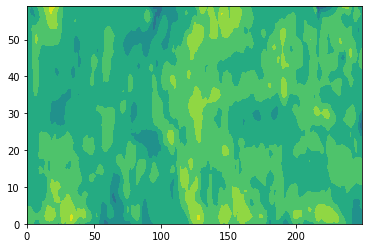

In [ ]:
ds_tpac=ds_anoms.sel(lat=slice(-30,30),lon=slice(30,280))
plt.contourf(ds_tpac['sst'][0,:,:])
ds_tpac

EOF analysis

In [ ]:
sst = ds_tpac['sst']

In [ ]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(ds_tpac.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eofs = solver.eofsAsCovariance(neofs=4)
#eofs = solver.eofsAsCorrelation(neofs=4)
pcs = solver.pcs(npcs=4, pcscaling=1)
vars = solver.varianceFraction(neigs=4)

In [ ]:
vars

<xarray.DataArray 'variance_fractions' (mode: 4)>
array([0.34928876, 0.11292719, 0.04787896, 0.03505719], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3
Attributes:
    long_name:  variance_fractions

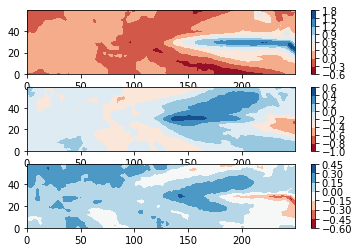

In [ ]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(eofs[i,:,:],cmap='RdBu')
    plt.colorbar()

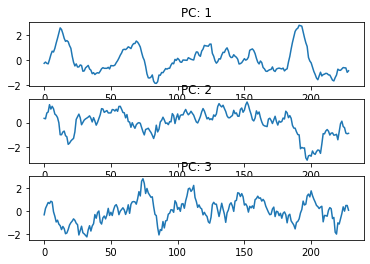

In [ ]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=pcs[:,i]
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)